In [1]:
from importlib import reload
from astropy import units as u
from astropy import constants as const
# from astropy.modeling.models import BlackBody
# from astropy.units.equivalencies import spectral

import math

import numpy as np
import matplotlib.pyplot as plt
import pandas
from scipy.interpolate import UnivariateSpline

# from scipy.special import expn
# from scipy.integrate import simpson

from src import astro530
from src import N_integrator

In [2]:
saha_LTE = astro530.saha_LTE
init_saha = astro530.init_saha

In [3]:
species = ["H","He","C", "Si", "Fe", "Mg", "Ni", "Cr", "Ca", "Na", "K"]

In [4]:
def initi():
    global a,b,c
    a = 5

In [5]:
def calc_Pe(species="H",T=4310*u.K,Pg=10**2.87*u.dyne/u.cm**2,Pe = None, Phi = None):
    try: ab_df
    except:
        try:
            ab_df = pandas.read_csv("data/SolarAbundance.csv").fillna("-")
        except:
            ab_df = pandas.read_csv("../data/SolarAbundance.csv").fillna("-")
    
    try:
        species = species[:]
    except:
        species = [species]
    
        
    # Units
    try:
        Pg = (Pg.to(u.dyne/u.cm**2)).value
        T = (T.to(u.K)).value
        if Pe != None: 
            Pe = (Pe.to(u.dyne/u.cm**2)).value
            
    except: pass
        
    A_list = []
    for element in species:
        try:
            A = 10**float((ab_df.loc[ab_df.element == element].logA).values[0])
        except:
            A = 0
        if element == "He":
            A_He = A
        A_list.append(A)
    A_arr = np.array(A_list)
    
    init_saha()
    
    if Pe == None:
        Pe = np.sqrt(saha_LTE(species="H",temp=T*u.K)*Pg)
#         Pe = Pg/(1+A_He)/A_He
#         for A in A_arr:
#             Pe *= A
    
    
    num = 0
    den = 0
    for i, element in enumerate(species):
        #print(element)
        try:
            phi = (Phi.loc[Phi.species==element].Phi).values[0]
        except:
            phi = saha_LTE(species=element,temp=T*u.K)
        num += A_arr[i]*(phi/Pe)/(1+phi/Pe)
        
        den += A_arr[i]*(1+(phi/Pe)/(1+phi/Pe))
    return Pg*u.dyne/u.cm**2*num/den

def true_Pe(species="H",T=5000*u.K,Pg=100*u.dyne/u.cm**2,tol=1e-8,single = False):
    dPe = 2*tol
    
    init_Abundance()
    
    if species == "all":
        species = []
        for element in ab_df.element:
            A = (ab_df.loc[ab_df.element == element].A).values[0]
            if A != "-" and A > tol:
                species.append(element)
    
    Phi = init_Phi(species=species,T=T)
    #print(Phi)
    
    Pe = calc_Pe(species=species,T=T,Pg = Pg, Phi = Phi)

    Pe_list = [Pe.value]

    while dPe > tol:
        Pe_new = calc_Pe(species=species,T=T,Pg=Pg,Pe=Pe.value, Phi = Phi)
        dPe = abs(Pe-Pe_new)/Pe_new
        Pe = Pe_new
        Pe_list.append(Pe.value)
    if single:
        return Pe
    else:
        return np.array(Pe_list)*Pe.unit
    
def init_Abundance():
    global ab_df
    try:
        ab_df = pandas.read_csv("data/SolarAbundance.csv").fillna("-")
    except:
        ab_df = pandas.read_csv("../data/SolarAbundance.csv").fillna("-")
def init_Phi(species=["H"],T=5000*u.K):
    data = [["species","Phi"]]
    for element in species:
        data.append([element,saha_LTE(species=element,temp=T)])
    #print(data[0])
    df = pandas.DataFrame(data=data[1:],
                    columns=data[0])
    return df
#     pandas.DataFrame(data=data[1:,1:],    # values
#                  index=data[1:,0],    # 1st column as index
#                  columns=data[0,1:])  # 1st row as the column names

In [6]:
saha_LTE(species="H",temp=5000*u.K)

1.1535095786178985e-05

In [7]:
calc_Pe(species=species)

<Quantity 0.07936128 dyn / cm2>

In [8]:
tol = 1e-10
T = 8718
Pg = 10**5.24

In [9]:
Pe_arr = true_Pe(species="all",T=T,Pg=Pg,tol=tol)
i_arr = np.arange(0,len(Pe_arr))

In [10]:
print(np.log10(Pe_arr[-1].value))

3.3530241013635287


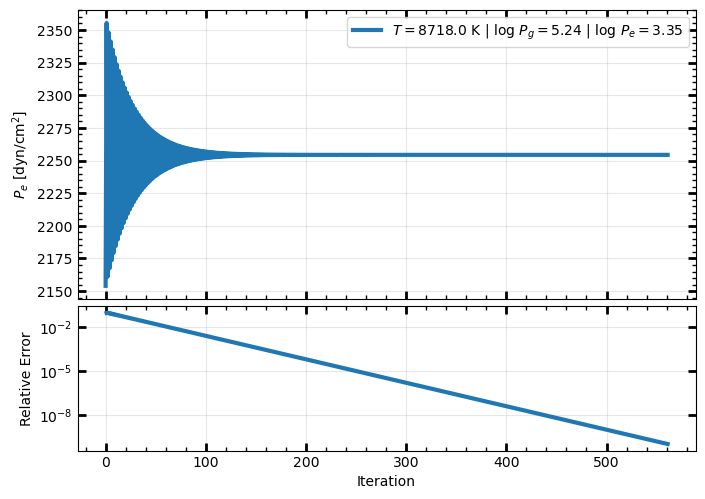

In [11]:
#fig, ax = plt.subplots(figsize = (7,5),nrows=1, ncols=1)
fig, (ax,ax2) = plt.subplots(figsize = (7,5), nrows = 2, ncols = 1, 
                                    gridspec_kw={'height_ratios': [2, 1]}, squeeze = True, sharex = True)
fig.tight_layout(h_pad=-.5)

    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

output_file = "plots/17a.pdf"
label = r"$T = $"+str((T*u.g/u.g).value*u.K)+r" | log $P_g = $"+str(round(np.log10((Pg*u.g/u.g).value),2))+r" | log $P_e = $"+str(round(np.log10(Pe_arr[-1].value),2))
ax.plot(i_arr,Pe_arr,lw=3,label=label)

ax2.set_xlabel(r"Iteration")
ax.set_ylabel(r"$P_e$ [dyn/cm$^2$]")
ax2.set_ylabel("Relative Error")

ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.grid(True,alpha=.3)

ax2.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax2.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

relE = []
for i in range(len(Pe_arr)):
    if i != 0:
        relE.append(abs(Pe_arr[i]-Pe_arr[i-1])/Pe_arr[i])
relE = np.array(relE)

ax2.plot(i_arr[1:],relE,lw=3)
ax2.set_yscale("log")
#ax2.set_xscale("log")
#ax.set_title(title)

ax.legend()

fig.savefig(output_file,bbox_inches='tight')

In [26]:
ab_df.loc[ab_df.atomic < 31]

,atomic,element,weight,A,logA,logA12
0,1,H,1.008,1.0,0.0,12.0
1,2,He,4.003,0.0851,-1.07,10.93
2,3,Li,6.941,0.0,-10.9,1.1
3,4,Be,9.012,0.0,-10.6,1.4
4,5,B,10.811,0.0,-9.45,2.55
5,6,C,12.011,0.000331,-3.48,8.52
6,7,N,14.007,0.000083,-4.08,7.92
7,8,O,15.994,0.000457,-3.34,8.66
8,9,F,18.998,0.0,-7.44,4.56
9,10,Ne,20.179,0.000069,-4.16,7.84


In [30]:
Atot = 0
Autot = 0
for i in range(2,32):
    Atot += (ab_df.iloc[i].A)
    Autot += (ab_df.iloc[i].A)*(ab_df.iloc[i].weight)
print("Abundance Sum = ",Atot)
print("Abundance Weight = ",Autot)

Abundance Sum =  0.0010752087016999998
Abundance Weight =  0.018452561426342797


In [17]:
ab_df.iloc[2].A

1.26e-11